In [1]:
%matplotlib nbagg

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

Hardware information:
```
Model name:          Intel(R) Xeon(R) CPU E3-1505M v5 @ 2.80GHz
Thread(s) per core:  2
Core(s) per socket:  4
Socket(s):           1
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            8192K
```

In [3]:
import numpy as np
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib/x86_64-linux-gnu']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib/x86_64-linux-gnu']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib/x86_64-linux-gnu']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/lib/x86_64-linux-gnu']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


OpenBLAS version:
```
$ dpkg -l libopenblas-base
ii  libopenblas-base:amd64   0.2.20+ds-4       amd64             Optimized BLAS (linear algebra) library (shared libra
```

In [4]:
import gc
import time
import seaborn
import pandas as pd
import matplotlib.pyplot as plt
from libertem.dataset.hdf5 import H5DataSet
from libertem.dataset.hdfs import BinaryHDFSDataSet
from libertem.executor.dask import DaskJobExecutor
from libertem.job.masks import ApplyMasksJob

/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
def make_masks(n=5, shape=(128, 128)):
    masks=[
        lambda: np.random.randn(*shape)
        for i in range(n)
    ]
    return masks

In [23]:
executor = DaskJobExecutor.make_local(cluster_kwargs={"threads_per_worker": 1, "n_workers": 1})
# executor = DaskJobExecutor(scheduler_uri="tcp://localhost:8786")


masks = make_masks(n=16)

def process_with_params(num_masks, stackheight):
    ds = BinaryHDFSDataSet(index_path="test/index.json", host='localhost', port=8020, tileshape=(1, stackheight, 128, 128))
    job = ApplyMasksJob(dataset=ds, mask_factories=masks[:num_masks])
    for result in executor.run_job(job):
        for tile in result:
            pass
    # TODO: ds.close()

In [24]:
%time process_with_params(num_masks=1, stackheight=8)

CPU times: user 438 ms, sys: 47.8 ms, total: 486 ms
Wall time: 1.66 s


In [25]:
results = []
for n_workers in range(1, 9):
    cluster = executor.client.cluster
    cluster.scale_up(n_workers, ncores=1)
    for num_masks in [1, 2, 4, 8, 16]:
        for stackheight in [4, 8]:
            for repeat in range(3):
                gc.collect()
                t0 = time.time()
                process_with_params(num_masks=num_masks + 1, stackheight=stackheight)
                t1 = time.time()
                result = {
                    "num_masks": num_masks,
                    "n_workers": n_workers,
                    "stackheight": stackheight,
                    "time": t1 - t0,
                }
                results.append(result)
                print(result)

{'num_masks': 1, 'n_workers': 1, 'stackheight': 4, 'time': 2.9843432903289795}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 4, 'time': 3.1899733543395996}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 4, 'time': 3.3624815940856934}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 8, 'time': 2.8224472999572754}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 8, 'time': 2.803712844848633}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 8, 'time': 2.658548593521118}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 4, 'time': 3.4237818717956543}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 4, 'time': 3.4887731075286865}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 4, 'time': 3.361959218978882}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 8, 'time': 2.9498798847198486}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 8, 'time': 2.9569849967956543}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 8, 'time': 2.975131034851074}
{'num_masks': 4, 'n_workers': 1, 'stackheight': 4, 'time

distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 1, 'stackheight': 8, 'time': 3.256237268447876}


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 1, 'stackheight': 8, 'time': 3.2614521980285645}


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 1, 'stackheight': 8, 'time': 3.3631532192230225}


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 1, 'stackheight': 4, 'time': 4.981247663497925}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 1, 'stackheight': 4, 'time': 4.993639945983887}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 1, 'stackheight': 4, 'time': 5.011265754699707}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 1, 'stackheight': 8, 'time': 3.9265544414520264}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 1, 'stackheight': 8, 'time': 4.127504825592041}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 1, 'stackheight': 8, 'time': 4.149514436721802}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 1, 'stackheight': 4, 'time': 6.907926797866821}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 1, 'stackheight': 4, 'time': 6.899520397186279}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 1, 'stackheight': 4, 'time': 7.031840562820435}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 1, 'stackheight': 8, 'time': 5.204087734222412}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 1, 'stackheight': 8, 'time': 5.377476930618286}
{'num_masks': 16, 'n_workers': 1, 'stackheight': 8, 'time': 5.397188425064087}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 2, 'stackheight': 4, 'time': 2.1226227283477783}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 2, 'stackheight': 4, 'time': 1.9551465511322021}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 2, 'stackheight': 4, 'time': 1.7174351215362549}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 2, 'stackheight': 8, 'time': 1.6137504577636719}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 2, 'stackheight': 8, 'time': 1.5103130340576172}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 2, 'stackheight': 8, 'time': 1.606985330581665}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 2, 'stackheight': 4, 'time': 1.9351284503936768}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 2, 'stackheight': 4, 'time': 1.9212055206298828}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 2, 'stackheight': 4, 'time': 1.8929145336151123}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 2, 'stackheight': 8, 'time': 1.879199743270874}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 2, 'stackheight': 8, 'time': 1.7856945991516113}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 2, 'stackheight': 8, 'time': 1.6847610473632812}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 2, 'stackheight': 4, 'time': 2.057931661605835}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 2, 'stackheight': 4, 'time': 2.0882787704467773}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 2, 'stackheight': 4, 'time': 2.1744577884674072}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 2, 'stackheight': 8, 'time': 1.8784379959106445}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 2, 'stackheight': 8, 'time': 1.892754316329956}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 2, 'stackheight': 8, 'time': 1.895000696182251}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 2, 'stackheight': 4, 'time': 2.9278125762939453}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 2, 'stackheight': 4, 'time': 2.6850810050964355}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 2, 'stackheight': 4, 'time': 2.7005434036254883}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 2, 'stackheight': 8, 'time': 2.3398706912994385}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 2, 'stackheight': 8, 'time': 2.305964469909668}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 2, 'stackheight': 8, 'time': 2.2119789123535156}


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 2, 'stackheight': 4, 'time': 3.9653828144073486}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 2, 'stackheight': 4, 'time': 4.055144786834717}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 2, 'stackheight': 4, 'time': 3.8926212787628174}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 2, 'stackheight': 8, 'time': 3.010387420654297}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 2, 'stackheight': 8, 'time': 3.1119041442871094}
{'num_masks': 16, 'n_workers': 2, 'stackheight': 8, 'time': 2.9227166175842285}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 4, 'time': 1.5371367931365967}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 4, 'time': 1.2963676452636719}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 4, 'time': 1.3158342838287354}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 8, 'time': 1.3170855045318604}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 8, 'time': 1.2836246490478516}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 8, 'time': 1.2857425212860107}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 4, 'time': 1.5793943405151367}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 4, 'time': 1.5174338817596436}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 4, 'time': 1.5721940994262695}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 8, 'time': 1.4640679359436035}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 8, 'time': 1.570408821105957}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 8, 'time': 1.4700539112091064}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 4, 'time': 1.746513843536377}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 4, 'time': 1.7280864715576172}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 4, 'time': 1.8014471530914307}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 8, 'time': 1.6881372928619385}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 8, 'time': 1.6655001640319824}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 8, 'time': 1.553504467010498}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 4, 'time': 2.117539167404175}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 4, 'time': 2.2896642684936523}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 4, 'time': 2.2984437942504883}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 8, 'time': 2.089189052581787}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 8, 'time': 2.156646490097046}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 8, 'time': 1.8931496143341064}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 4, 'time': 3.0304434299468994}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 4, 'time': 3.370190143585205}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 4, 'time': 3.064574956893921}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 8, 'time': 2.5768470764160156}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 8, 'time': 2.6019186973571777}
{'num_masks': 16, 'n_workers': 3, 'stackheight': 8, 'time': 2.5966484546661377}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 4, 'time': 1.2983348369598389}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 4, 'time': 1.1673974990844727}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 4, 'time': 1.1375608444213867}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 8, 'time': 1.1301307678222656}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 8, 'time': 1.2326254844665527}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 8, 'time': 1.2466192245483398}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 4, 'time': 1.3638832569122314}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 4, 'time': 1.342775821685791}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 4, 'time': 1.3176648616790771}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 8, 'time': 1.2264413833618164}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 8, 'time': 1.2899703979492188}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 8, 'time': 1.244347095489502}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 4, 'time': 1.5069375038146973}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 4, 'time': 1.5280227661132812}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 4, 'time': 1.6010282039642334}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 8, 'time': 1.3992609977722168}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 8, 'time': 1.4272122383117676}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 8, 'time': 1.4105768203735352}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 4, 'time': 2.0350308418273926}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 4, 'time': 1.816227912902832}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 4, 'time': 1.9472737312316895}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 8, 'time': 1.7017261981964111}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 8, 'time': 1.753180980682373}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 8, 'time': 1.8132383823394775}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 4, 'time': 2.7559053897857666}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 4, 'time': 2.533738613128662}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 4, 'time': 2.830599546432495}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 8, 'time': 2.1592962741851807}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 8, 'time': 2.212705373764038}
{'num_masks': 16, 'n_workers': 4, 'stackheight': 8, 'time': 2.2040505409240723}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 4, 'time': 1.2147109508514404}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 4, 'time': 1.1276986598968506}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 4, 'time': 1.0698115825653076}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 8, 'time': 1.2336311340332031}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 8, 'time': 1.2185568809509277}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 8, 'time': 1.2113971710205078}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 4, 'time': 1.2525248527526855}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 4, 'time': 1.274709939956665}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 4, 'time': 1.2833757400512695}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 8, 'time': 1.312758207321167}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 8, 'time': 1.3382701873779297}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 8, 'time': 1.3748395442962646}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 4, 'time': 1.4471540451049805}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 4, 'time': 1.5210254192352295}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 4, 'time': 1.542356014251709}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 8, 'time': 1.5263619422912598}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 8, 'time': 1.4378950595855713}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 8, 'time': 1.511556625366211}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 4, 'time': 1.8998923301696777}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 4, 'time': 1.9539177417755127}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 4, 'time': 2.0166690349578857}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 8, 'time': 1.6432013511657715}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 8, 'time': 1.8938238620758057}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 8, 'time': 1.8893818855285645}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 4, 'time': 2.6162290573120117}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 4, 'time': 2.8455617427825928}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 4, 'time': 2.9993412494659424}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 8, 'time': 2.3734471797943115}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 8, 'time': 2.300957202911377}
{'num_masks': 16, 'n_workers': 5, 'stackheight': 8, 'time': 2.3619208335876465}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 4, 'time': 1.1966612339019775}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 4, 'time': 1.1329376697540283}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 4, 'time': 1.0943043231964111}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 8, 'time': 1.2016472816467285}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 8, 'time': 1.165123701095581}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 8, 'time': 1.1708736419677734}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 4, 'time': 1.1895618438720703}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 4, 'time': 1.2219464778900146}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 4, 'time': 1.2397966384887695}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 8, 'time': 1.3535492420196533}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 8, 'time': 1.3129072189331055}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 8, 'time': 1.3045494556427002}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 4, 'time': 1.4235806465148926}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 4, 'time': 1.3568828105926514}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 4, 'time': 1.4528439044952393}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 8, 'time': 1.407414436340332}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 8, 'time': 1.5322201251983643}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 8, 'time': 1.4449372291564941}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 4, 'time': 1.8534297943115234}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 4, 'time': 1.856302261352539}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 4, 'time': 1.9089481830596924}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 8, 'time': 1.8031737804412842}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 8, 'time': 1.763683557510376}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 8, 'time': 1.7343337535858154}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 4, 'time': 2.5101048946380615}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 4, 'time': 2.6058526039123535}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 4, 'time': 2.8406479358673096}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 8, 'time': 2.249457359313965}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 8, 'time': 2.1919803619384766}
{'num_masks': 16, 'n_workers': 6, 'stackheight': 8, 'time': 2.2655410766601562}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 4, 'time': 1.1848773956298828}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 4, 'time': 1.1706395149230957}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 4, 'time': 1.0564243793487549}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 8, 'time': 1.3065671920776367}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 8, 'time': 1.277602195739746}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 8, 'time': 1.2847304344177246}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 4, 'time': 1.2300002574920654}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 4, 'time': 1.250882625579834}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 4, 'time': 1.2826972007751465}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 8, 'time': 1.3793072700500488}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 8, 'time': 1.3060657978057861}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 8, 'time': 1.3809444904327393}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 4, 'time': 1.4450321197509766}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 4, 'time': 1.4436264038085938}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 4, 'time': 1.4128825664520264}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 8, 'time': 1.6072125434875488}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 8, 'time': 1.7114105224609375}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 8, 'time': 1.5761148929595947}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 4, 'time': 1.9296491146087646}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 4, 'time': 2.0044195652008057}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 4, 'time': 2.0259459018707275}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 8, 'time': 1.9210381507873535}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 8, 'time': 1.8645970821380615}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 8, 'time': 1.83974289894104}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 4, 'time': 2.869683265686035}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 4, 'time': 2.849926710128784}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 4, 'time': 2.837094783782959}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 8, 'time': 2.0966107845306396}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 8, 'time': 2.4570701122283936}
{'num_masks': 16, 'n_workers': 7, 'stackheight': 8, 'time': 2.359351634979248}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 4, 'time': 1.1607916355133057}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 4, 'time': 1.2087466716766357}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 4, 'time': 1.147874355316162}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 8, 'time': 1.301429271697998}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 8, 'time': 1.2669055461883545}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 8, 'time': 1.2812731266021729}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 4, 'time': 1.3772075176239014}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 4, 'time': 1.267115592956543}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 4, 'time': 1.323582649230957}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 8, 'time': 1.3726234436035156}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 8, 'time': 1.4099245071411133}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 8, 'time': 1.4512932300567627}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 4, 'time': 1.67411470413208}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 4, 'time': 1.504690408706665}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 4, 'time': 1.4597187042236328}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 8, 'time': 1.5220329761505127}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 8, 'time': 1.5376996994018555}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 8, 'time': 1.5190131664276123}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 4, 'time': 2.045088529586792}


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 4, 'time': 1.9336214065551758}


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 4, 'time': 1.9742305278778076}


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 8, 'time': 1.8452787399291992}


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 8, 'time': 1.8737311363220215}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 8, 'time': 1.8943374156951904}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 4, 'time': 2.894580125808716}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 4, 'time': 2.808317184448242}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 4, 'time': 2.83225679397583}


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 8, 'time': 2.4775044918060303}


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 8, 'time': 2.38944673538208}
{'num_masks': 16, 'n_workers': 8, 'stackheight': 8, 'time': 2.4131054878234863}


In [26]:
df = pd.DataFrame(results)

<IPython.core.display.Javascript object>


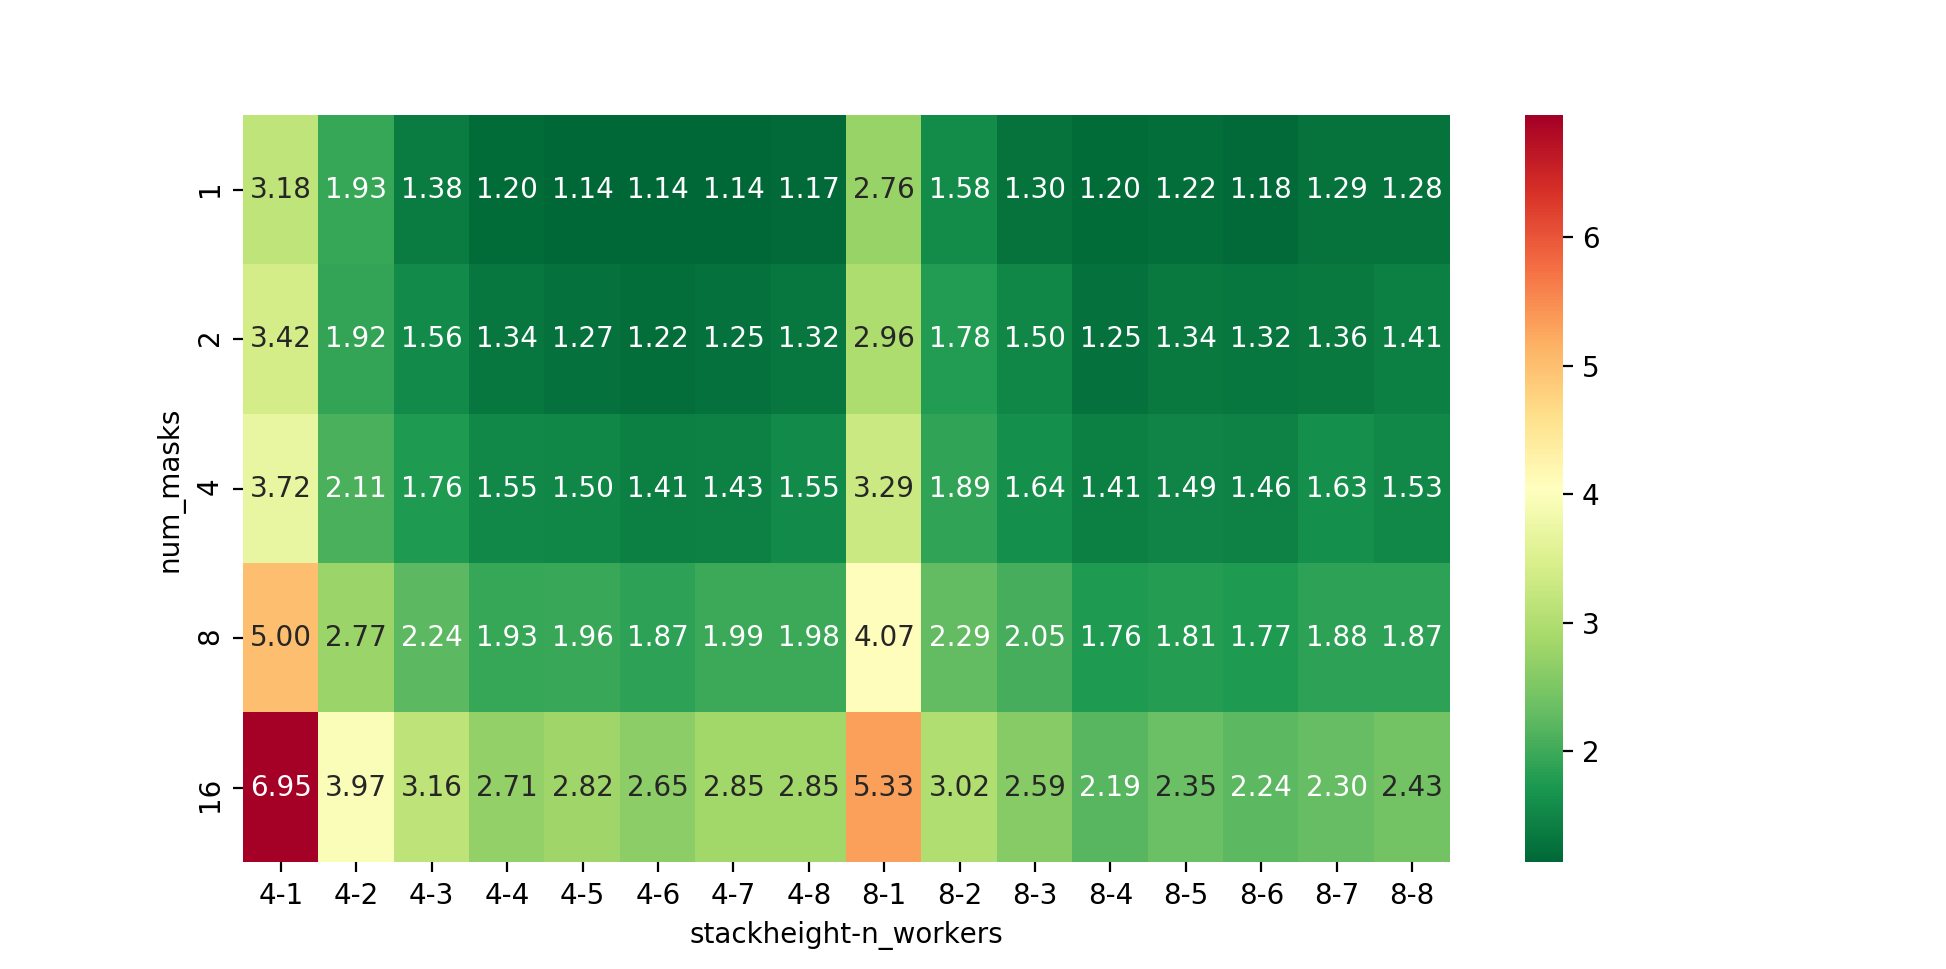

In [27]:
table = df.pivot_table(values='time', columns=['stackheight', "n_workers"], index=["num_masks"])
cmap = "RdYlGn_r"
seaborn.heatmap(table, annot=True, cmap=cmap, fmt=".2f")
plt.show()

<IPython.core.display.Javascript object>


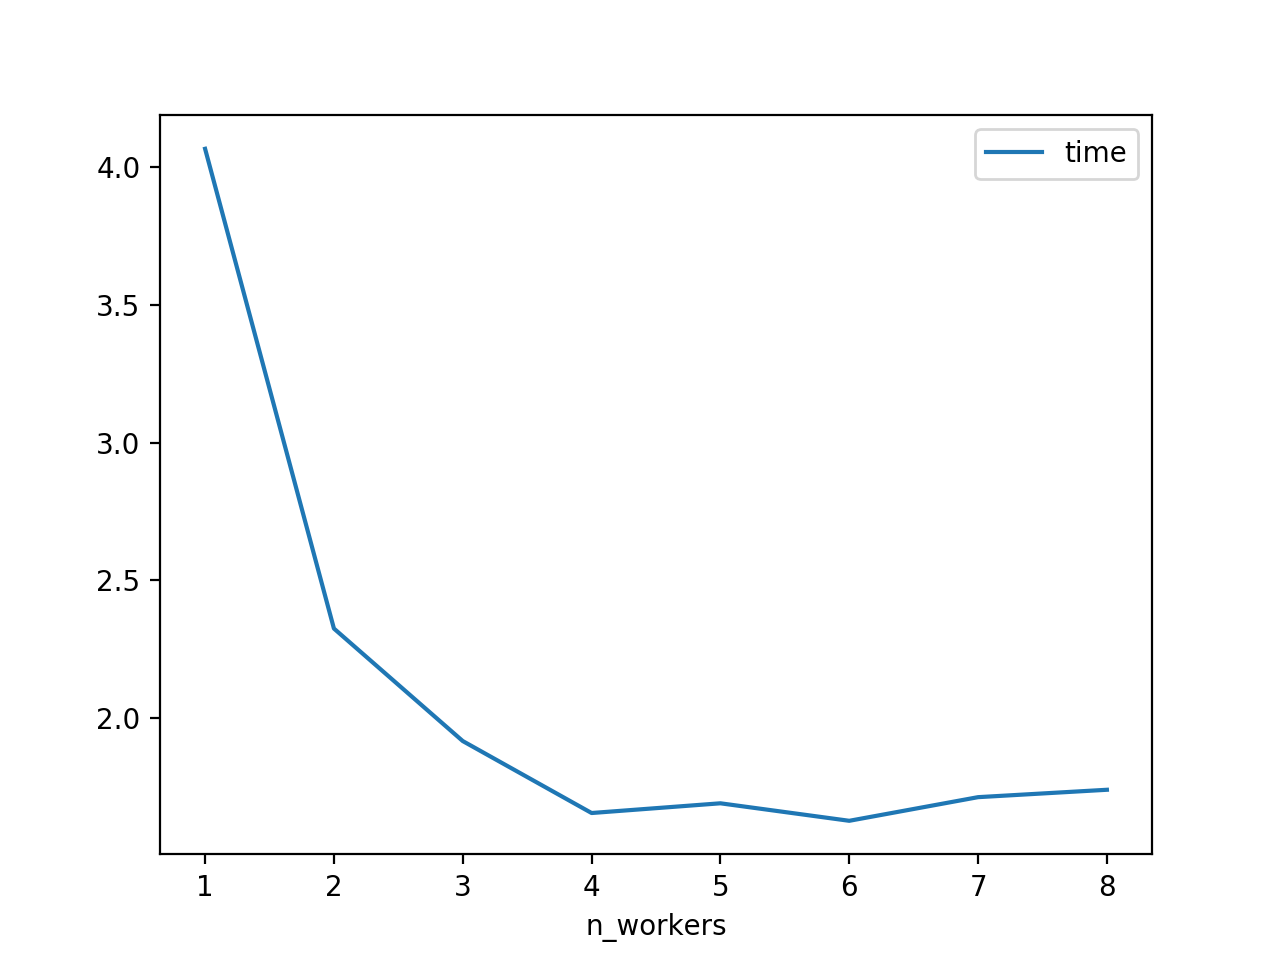

In [28]:
df.groupby(["n_workers"]).mean()[["time"]].plot()

In [29]:
df2 = pd.merge(
    df[df.stackheight == 4].groupby("n_workers")["n_workers", "time"].mean(),
    df[df.stackheight == 8].groupby("n_workers")["n_workers", "time"].mean(),
    on="n_workers",
)

In [30]:
df2

,n_workers,time_x,time_y
0,1,4.453551,3.681992
1,2,2.539447,2.109981
2,3,2.017684,1.814168
3,4,1.745492,1.563425
4,5,1.737665,1.641867
5,6,1.658920,1.593426
6,7,1.732919,1.691224
7,8,1.774129,1.703707


<IPython.core.display.Javascript object>


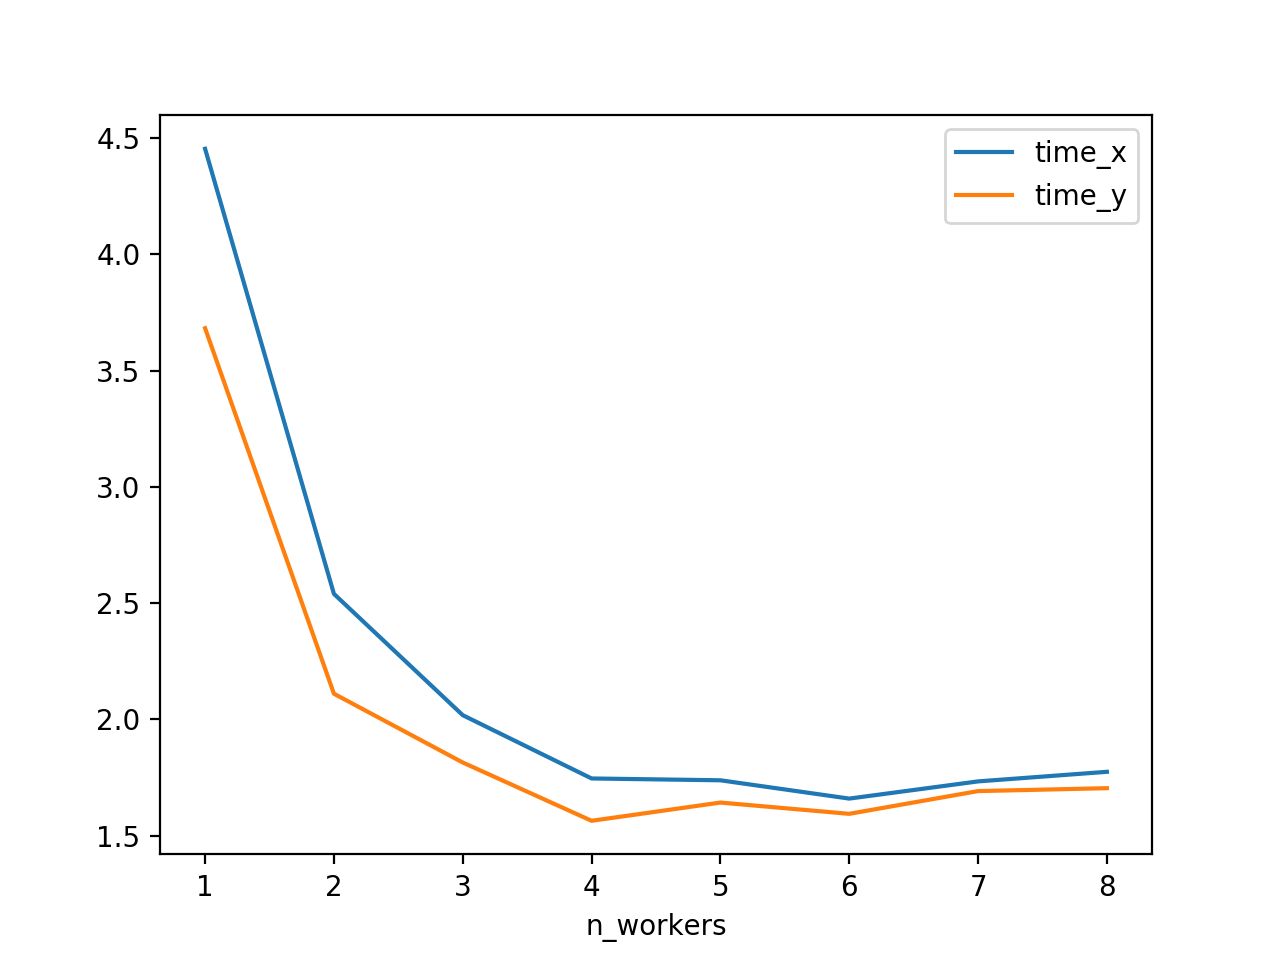

In [31]:
df2.set_index('n_workers').plot()

In [32]:
len(results)

240